<a target="_blank" href="https://colab.research.google.com/github/skojaku/adv-net-sci/blob/main/notebooks/exercise-m03-robustness.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
# If you are using Google Colab, uncomment the following line to install igraph
# !sudo apt install libcairo2-dev pkg-config python3-dev
# !pip install pycairo cairocffi
# !pip install igraph

# Hands-on: Robustness

We consider a small social network of 34 members in a university karate club, called Zachary's karate club network.

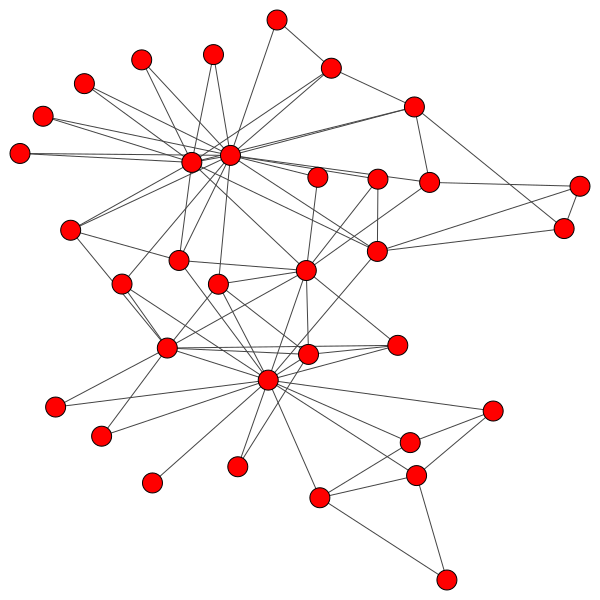

In [1]:
import igraph
g = igraph.Graph.Famous("Zachary")
igraph.plot(g, vertex_size=20)

Let's break the network 😈!
We will remove nodes one by one and see how the connectivity of the network changes at each step.
It is useful to create a copy of the network to keep the original network unchanged.

In [2]:
g_original = g.copy()

## Robustness against random failures

Let us remove a single node from the network. To this end, we need to first identify which nodes are in the network. With `igraph`, the IDs of the nodes in a graph are accessible through `Graph.vs.indices` as follows:

In [ ]:
print(g.vs.indices)

We randomly choose a node and remove it from the network by using `Graph.delete_vertices`.

In [6]:
import numpy as np
node_idx = np.random.choice(g.vs.indices)
g.delete_vertices(node_idx)
print("Node removed:", node_idx)
print("Nodes remaining:", g.vs.indices)
print("Number of nodes remaining:", g.vcount())

Node removed: 6
Nodes remaining: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Number of nodes remaining: 30


:::{note}
`np.random.choice(array)` takes an array `array` and returns a single element from the array.
For example, `np.random.choice(np.array([1, 2, 3]))` returns either 1, 2, or 3 with equal probability.
See [the documentation](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) for more details.
:::

The connectivity of the network is the fraction of nodes in the largest connected component of the network after node removal.
We can get the connected components of the network by using `Graph.connected_components`.

In [7]:
components = g.connected_components()

The sizes of the connected components are accessible via `Graph.connected_components.sizes`.

In [8]:
components.sizes()

[30]

Thus, the connectivity of the network can be computed by

In [9]:
components = g.connected_components()
connectivity = np.max(components.sizes()) / g_original.vcount()
connectivity

0.8823529411764706

### 📊 Exercise: Draw the robustness profile

In this exercise, we'll create a robustness profile for the network.
Follow these steps:
1. Remove nodes randomly one by one
2. Calculate the connectivity after each removal
3. Plot the connectivity vs. fraction of nodes removed

Let us plot the robustness profile.

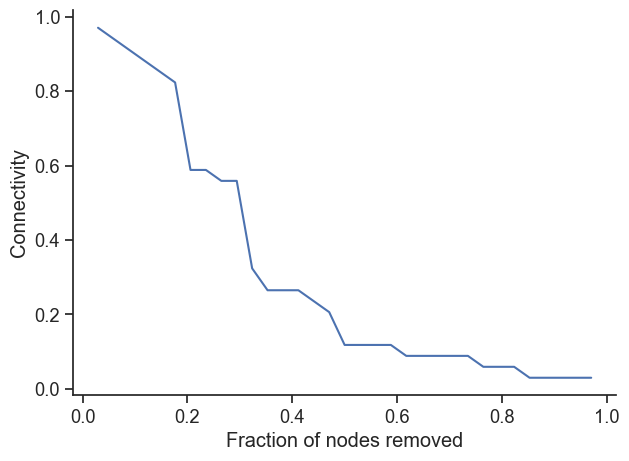

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

n_nodes = g_original.vcount()
g = g_original.copy()

results = []
for i in range(n_nodes-1):

    # Remove the node with the largest degree
    degree = g.degree()
    node_idx = np.random.choice(g.vs.indices)
    g.delete_vertices(node_idx)

    # Compute the connectivity
    connectivity = np.max(g.connected_components().sizes()) / g_original.vcount()

    # Store the connectivity
    results.append({"connectivity": connectivity, "node_removed": 1-g.vcount() / n_nodes})

df_random = pd.DataFrame(results)

# Plot
sns.set_style('white')
sns.set(font_scale=1.2)
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(7,5))

ax = sns.lineplot(data = df_random, x = "node_removed", y = "connectivity", ax = ax)
ax.set_xlabel("Fraction of nodes removed")
ax.set_ylabel("Connectivity")
sns.despine()
#fig.savefig(output_file, bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)

How should we interpret the robustness profile? Consider the most robust network consisting of $N$ nodes, where all $N$ nodes are fully connected. Regardless of how many nodes are removed, there will always be a single connected component, and the size of this component will be $N-k$ if $k$ nodes are removed. Therefore, the connectivity is $(N-k)/N=1-k/N$, which corresponds to the diagonal line in the plot above.
Hence, **a network is considered robust if its connectivity curve is close to the diagonal line**.
On the other hand, if the curve is significantly lower than the diagonal line, the network is not robust.

For the network we considered above, the robustness profile is close to the diagonal line, indicating that the network is robust to the random removal of nodes.

:::{note}
The random attack is stochastic, meaning that the robustness profile has a variation in each run. Thus, it is necessary to run the attack multiple times and average the results to get a more accurate estimate of the robustness.
:::

## Targeted attack

In a targeted attack, nodes are removed based on specific criteria rather than randomly.
One common strategy is to remove nodes from the largest node degree to the smallest, based on the idea that removing nodes with many edges is more likely to disrupt the network connectivity.

The degree of the nodes is accessible via `Graph.degree`.

In [ ]:
print(g_original.degree())

### Exercise 02: 

We compute the robustness profile by removing nodes with the largest degree and measuring the connectivity of the network after each removal. Recompute the degree of the nodes after each removal.

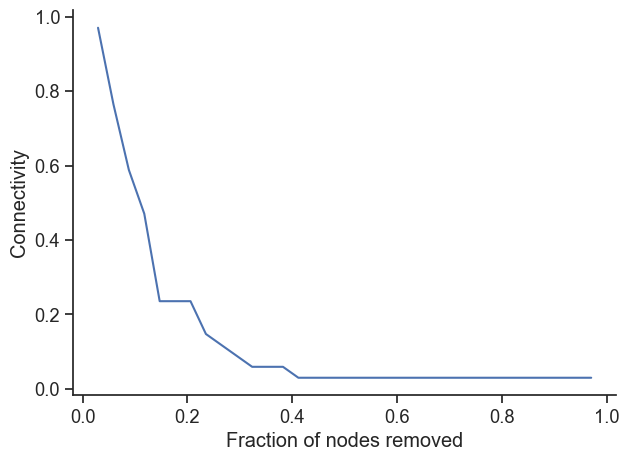

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

n_nodes = g_original.vcount()
g = g_original.copy()

results = []
for i in range(n_nodes-1):

    # Remove the node with the largest degree
    degree = g.degree()
    node_idx = g.vs.indices[np.argmax(degree)]
    g.delete_vertices(node_idx)

    # Compute the connectivity
    connectivity = np.max(g.connected_components().sizes()) / g_original.vcount()

    # Store the connectivity
    results.append({"connectivity": connectivity, "node_removed": 1-g.vcount() / n_nodes})

df_targeted = pd.DataFrame(results)

# Plot
sns.set_style('white')
sns.set(font_scale=1.2)
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(7,5))

ax = sns.lineplot(data = df_targeted, x = "node_removed", y = "connectivity", ax = ax)
ax.set_xlabel("Fraction of nodes removed")
ax.set_ylabel("Connectivity")
sns.despine()
#fig.savefig(output_file, bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)

### Exercise 03

Compute the robustness index for the degree-based targetted attack and random failures

In [19]:
# Your code

R_index_targeted = df_targeted["connectivity"].mean()
R_index_random = df_random["connectivity"].mean()

print(f"R-index for targeted attack: {R_index_targeted}")
print(f"R-index for random failures: {R_index_random}")

R-index for targeted attack: 0.13992869875222816
R-index for random failures: 0.3172905525846702


The targeted attack has a smaller $R$-index, indicating that the network is less robust to the targeted attack compared to the random attack.